In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
import lightgbm as lgb
import xgboost as xgb
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [2]:
# Load the processed data
import pickle
with open('../data/processed_oil_gas_data.pickle', 'rb') as f:
    processed_data = pickle.load(f)

X_train = processed_data['X_train']
X_val = processed_data['X_val']
X_test = processed_data['X_test']
y_train = processed_data['y_train']
y_val = processed_data['y_val']
y_test = processed_data['y_test']
feature_names = processed_data['feature_names']
preprocessor = processed_data['preprocessor']

print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Test set shape: {X_test.shape}")

# Also load the original data to access the date and hierarchical information
df = pd.read_parquet('../data/oil_and_gas_dataset.parquet')

Training set shape: (541998, 744)
Validation set shape: (6389, 744)
Test set shape: (8114, 744)


In [3]:
# Function to evaluate model performance
def evaluate_model(model, X, y, model_name="Model"):
    y_pred = model.predict(X)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    mae = mean_absolute_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    
    print(f"{model_name} Performance:")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R²: {r2:.4f}")
    
    return {'rmse': rmse, 'mae': mae, 'r2': r2, 'predictions': y_pred}

# Function to plot actual vs predicted values
def plot_predictions(y_true, y_pred, title="Actual vs Predicted"):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, y_pred, alpha=0.5)
    
    # Add perfect prediction line
    min_val = min(min(y_true), min(y_pred))
    max_val = max(max(y_true), max(y_pred))
    plt.plot([min_val, max_val], [min_val, max_val], 'r--')
    
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(title)
    plt.grid(True)
    plt.show()
    
    # Plot residuals
    residuals = y_true - y_pred
    plt.figure(figsize=(10, 6))
    plt.scatter(y_pred, residuals, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title(f'Residuals Plot - {title}')
    plt.grid(True)
    plt.show()
    
    # Plot histogram of residuals
    plt.figure(figsize=(10, 6))
    plt.hist(residuals, bins=50, alpha=0.75)
    plt.xlabel('Residual Value')
    plt.ylabel('Frequency')
    plt.title(f'Residuals Distribution - {title}')
    plt.grid(True)
    plt.show()

# Function to plot feature importance
def plot_feature_importance(model, feature_names, title="Feature Importance"):
    if hasattr(model, 'feature_importances_'):
        # Get feature importances
        importances = model.feature_importances_
        
        # Create DataFrame for visualization
        feature_importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': importances
        })
        
        # Sort by importance
        feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False).head(20)
        
        # Plot
        plt.figure(figsize=(12, 8))
        sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
        plt.title(title)
        plt.tight_layout()
        plt.show()
    else:
        print("This model doesn't have feature_importances_ attribute.")

# Training the models


Training Random Forest Regressor...
Random Forest (Validation) Performance:
RMSE: 0.6938
MAE: 0.4827
R²: 0.4508


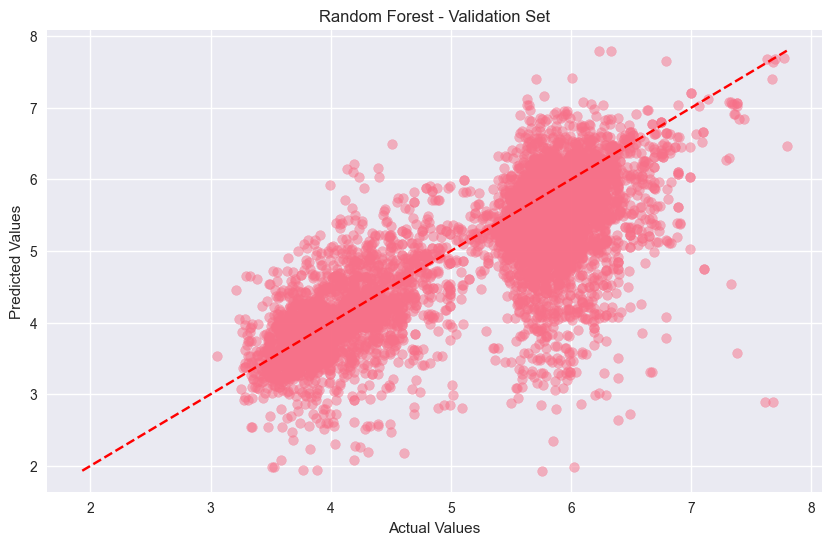

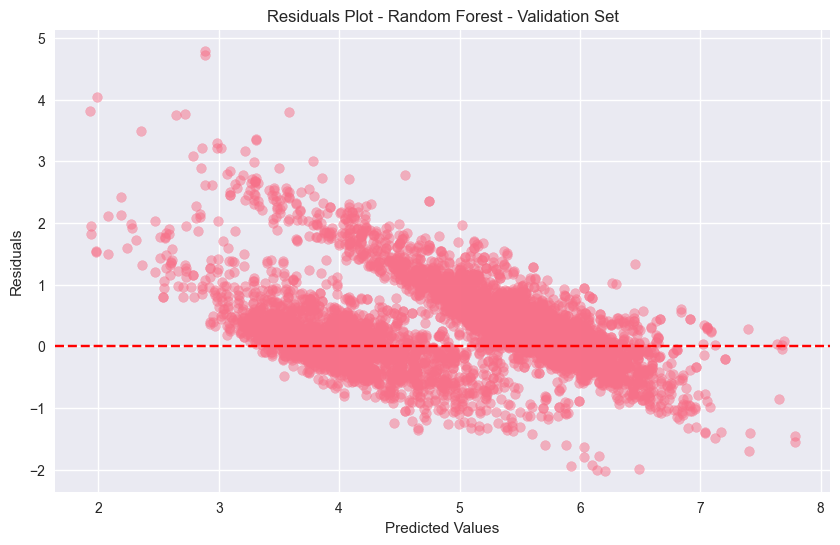

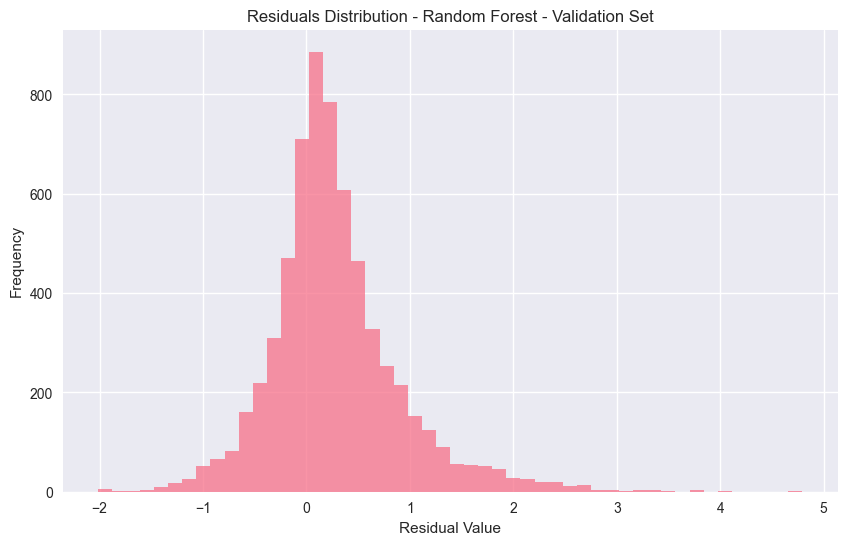

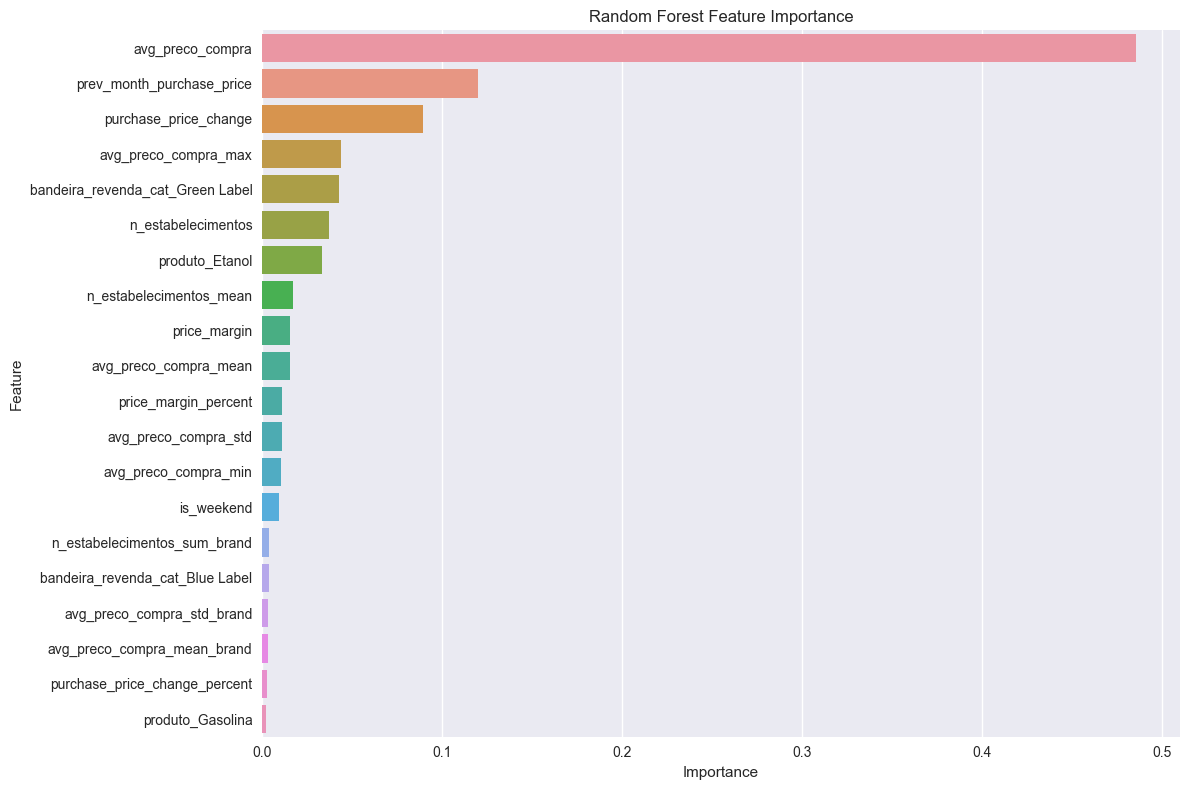

In [4]:
# 1. Random Forest Regressor
print("\nTraining Random Forest Regressor...")
rf_model = RandomForestRegressor(n_estimators=10, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

# Evaluate on validation set
rf_val_results = evaluate_model(rf_model, X_val, y_val, "Random Forest (Validation)")
plot_predictions(y_val, rf_val_results['predictions'], "Random Forest - Validation Set")
plot_feature_importance(rf_model, feature_names, "Random Forest Feature Importance")



In [5]:
# #  LightGBM Regressor
# print("\nTraining LightGBM Regressor...")
# lgb_model = lgb.LGBMRegressor(n_estimators=10, random_state=42)
# lgb_model.fit(X_train, y_train)

# # Evaluate on validation set
# lgb_val_results = evaluate_model(lgb_model, X_val, y_val, "LightGBM (Validation)")
# plot_predictions(y_val, lgb_val_results['predictions'], "LightGBM - Validation Set")
# plot_feature_importance(lgb_model, feature_names, "LightGBM Feature Importance")


Training XGBoost Regressor...
XGBoost (Validation) Performance:
RMSE: 1.0289
MAE: 0.8661
R²: -0.2079


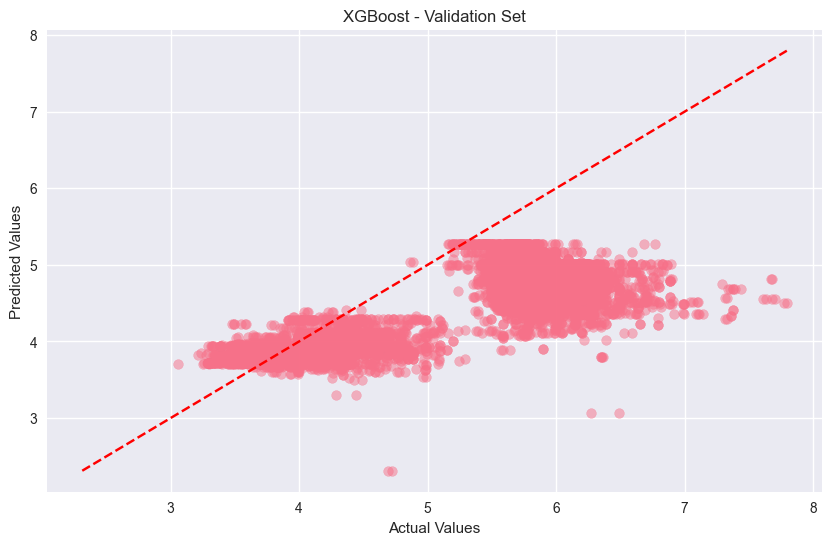

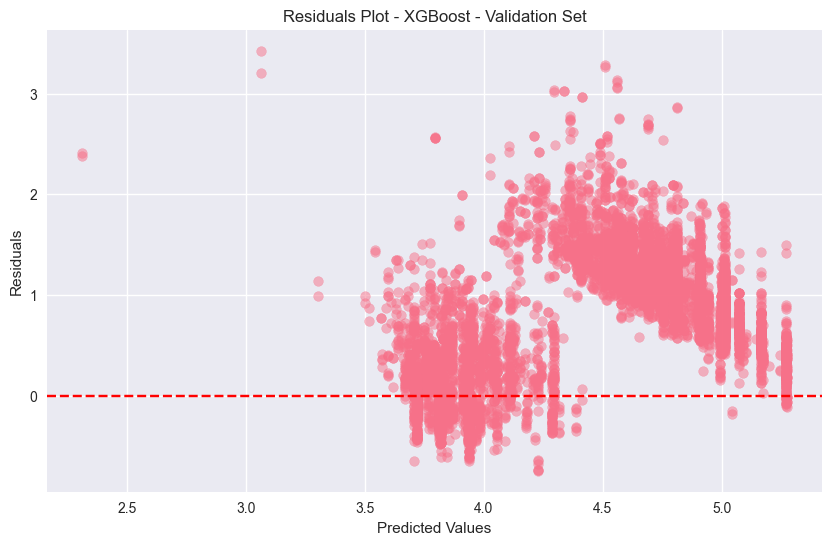

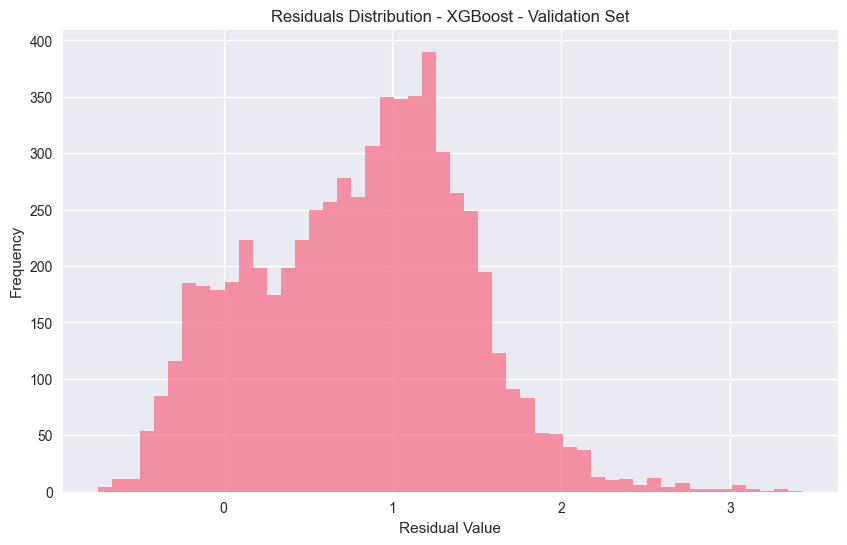

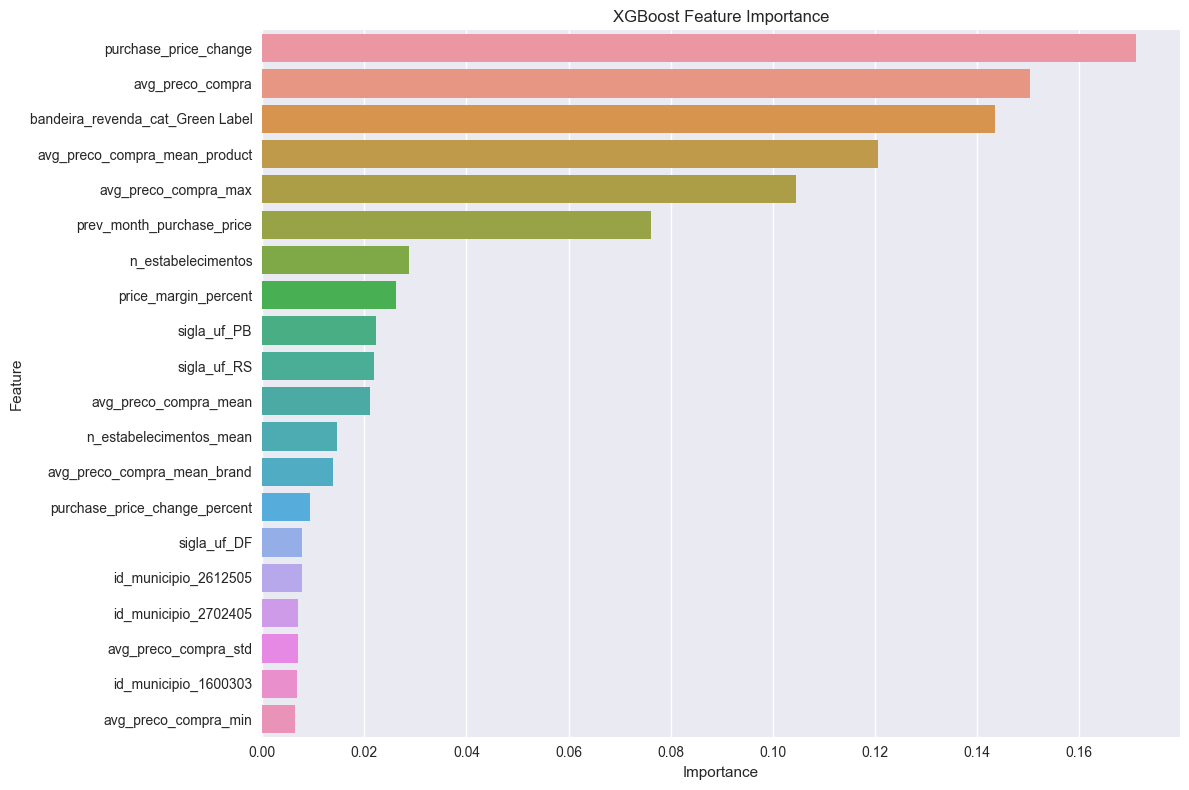

In [6]:
# 4. XGBoost Regressor
print("\nTraining XGBoost Regressor...")
xgb_model = xgb.XGBRegressor(n_estimators=10, random_state=42)
xgb_model.fit(X_train, y_train)

# Evaluate on validation set
xgb_val_results = evaluate_model(xgb_model, X_val, y_val, "XGBoost (Validation)")
plot_predictions(y_val, xgb_val_results['predictions'], "XGBoost - Validation Set")
plot_feature_importance(xgb_model, feature_names, "XGBoost Feature Importance")

In [7]:
# Saving the models
# Create a directory for saving models if it doesn't exist
import os
if not os.path.exists('../models'):
    os.makedirs('../models', exist_ok=True)

# Save the Random Forest model
print("\nSaving Random Forest model...")
import joblib
joblib.dump(rf_model, '../models/random_forest_model.pkl')

# # Save the LightGBM model
# print("\nSaving LightGBM model...")
# lgb_model.save_model('../models/lightgbm_model.txt')

# Save the XGBoost model
print("\nSaving XGBoost model...")
joblib.dump(xgb_model, '../models/xgboost_model.pkl')

# Save model evaluation results
print("\nSaving model evaluation results...")
import json
model_results = {
    'random_forest': rf_val_results,
    # 'lightgbm': lgb_val_results,
    'xgboost': xgb_val_results
}

# Convert numpy values to Python native types for JSON serialization
for model_name, results in model_results.items():
    for metric, value in results.items():
        if metric != 'predictions':  # Skip predictions array
            model_results[model_name][metric] = float(value)
    # Remove predictions from results to save space
    if 'predictions' in model_results[model_name]:
        del model_results[model_name]['predictions']

# Save results as JSON
with open('../models/model_evaluation_results.json', 'w') as f:
    json.dump(model_results, f, indent=4)

print("All models and evaluation results saved successfully!")



Saving Random Forest model...

Saving XGBoost model...

Saving model evaluation results...
All models and evaluation results saved successfully!


# Model selection and final evaluation on test set

In [8]:
print("\n===== Model Selection and Final Evaluation =====\n")

# Compare validation results
models_comparison = pd.DataFrame({
    'Model': ['Random Forest', 'XGBoost'],
    'RMSE': [rf_val_results['rmse'], xgb_val_results['rmse']],
    'MAE': [rf_val_results['mae'], xgb_val_results['mae']],
    'R²': [rf_val_results['r2'], xgb_val_results['r2']]
})

# Sort by RMSE (lower is better)
models_comparison = models_comparison.sort_values('RMSE')
print("\nModels Comparison on Validation Set:")
display(models_comparison)


===== Model Selection and Final Evaluation =====


Models Comparison on Validation Set:


,Model,RMSE,MAE,R²
0,Random Forest,0.693775,0.482695,0.450785
1,XGBoost,1.028879,0.866095,-0.207907


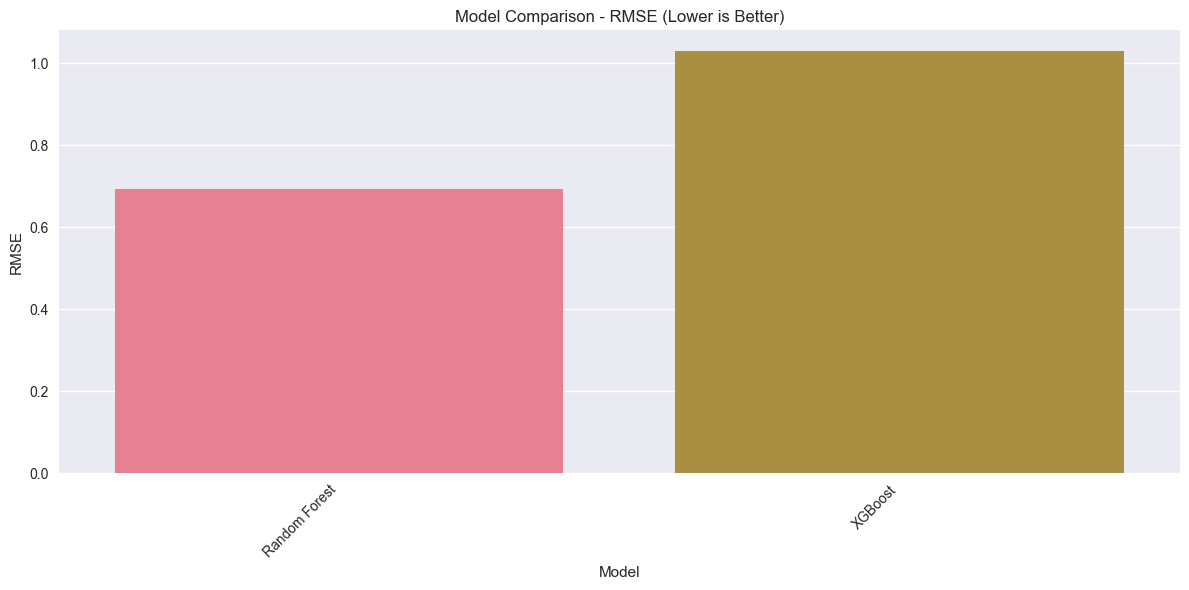


Best model based on validation RMSE: Random Forest
Random Forest (Test) Performance:
RMSE: 0.8525
MAE: 0.6122
R²: 0.1382


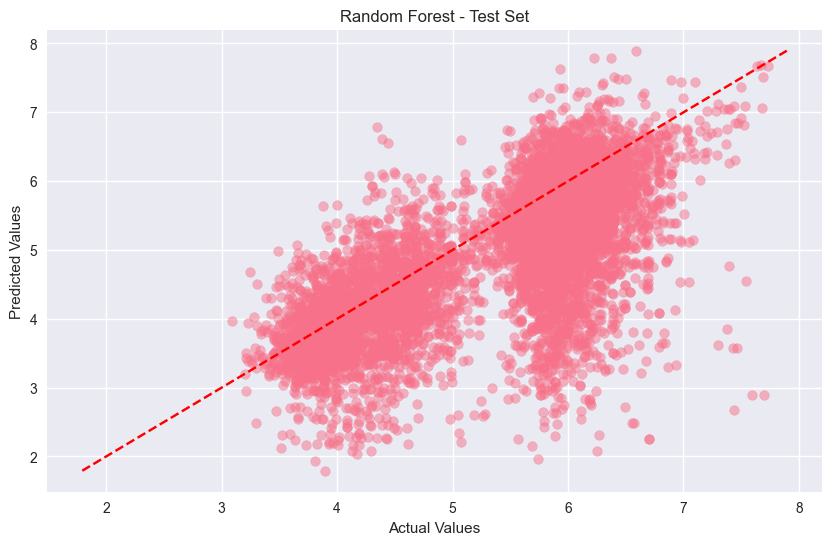

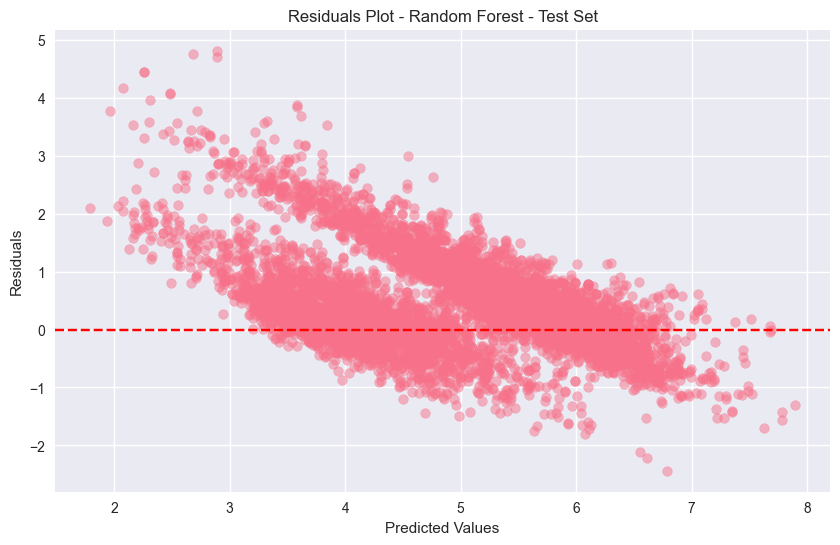

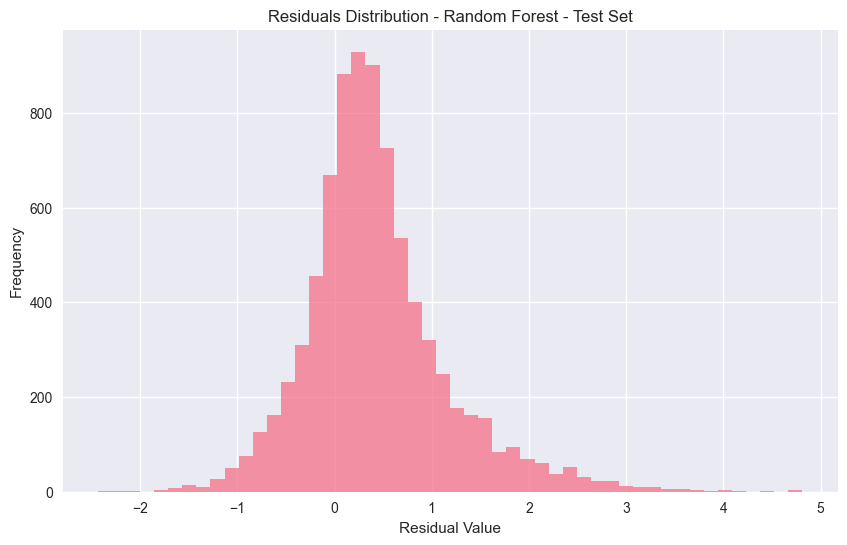

In [9]:
# Visualize model comparison
plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='RMSE', data=models_comparison)
plt.title('Model Comparison - RMSE (Lower is Better)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Select the best model based on validation RMSE
best_model_name = models_comparison.iloc[0]['Model']
print(f"\nBest model based on validation RMSE: {best_model_name}")

# Evaluate the best model on the test set
if best_model_name == 'Random Forest':
    best_model = rf_model
    test_results = evaluate_model(best_model, X_test, y_test, "Random Forest (Test)")
    plot_predictions(y_test, test_results['predictions'], "Random Forest - Test Set")
elif best_model_name == 'XGBoost':
    best_model = xgb_model
    test_results = evaluate_model(best_model, X_test, y_test, "XGBoost (Test)")
    plot_predictions(y_test, test_results['predictions'], "XGBoost - Test Set")
